# Linear regression project - predicting the sale price of homes

# Data exploration and feature design

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
import h2o

In [2]:
# read in training data
housing_train = pd.read_csv('../data/processed/train_clean.csv', index_col = 'Id', keep_default_na = False)

## 1. Exploration of target variable

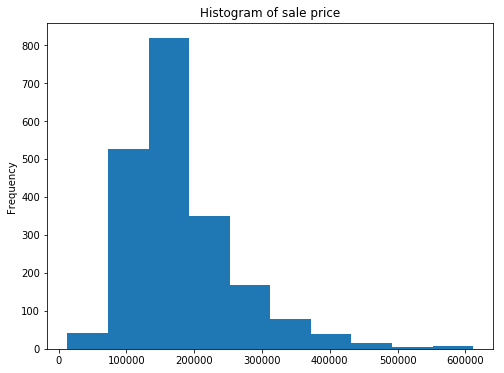

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
housing_train['SalePrice'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of sale price');

In [4]:
## Target variable is right skewed, whereas we want a normally distributed target for linear regression

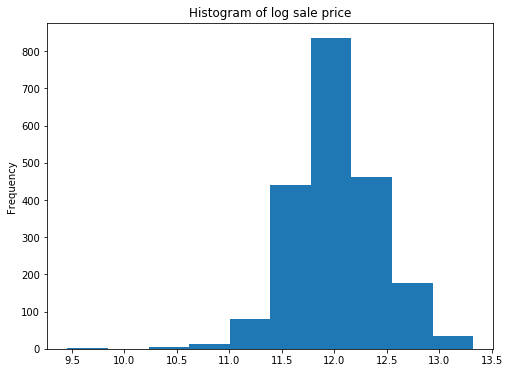

In [5]:
# log transform price to get a more normally distributed target
housing_train['Log Price'] = np.log(housing_train['SalePrice'])

fig, ax = plt.subplots(figsize=(8,6))
housing_train['Log Price'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of log sale price');

## 2. Exploration of features

### Scatter plots

In [86]:
housing_train.shape

(2051, 81)

In [78]:
def scatter_plot(x,y,ax):
    ax.scatter(housing_train[x], housing_train[y], alpha=0.2)
    ax.set_title(y+' by '+x)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

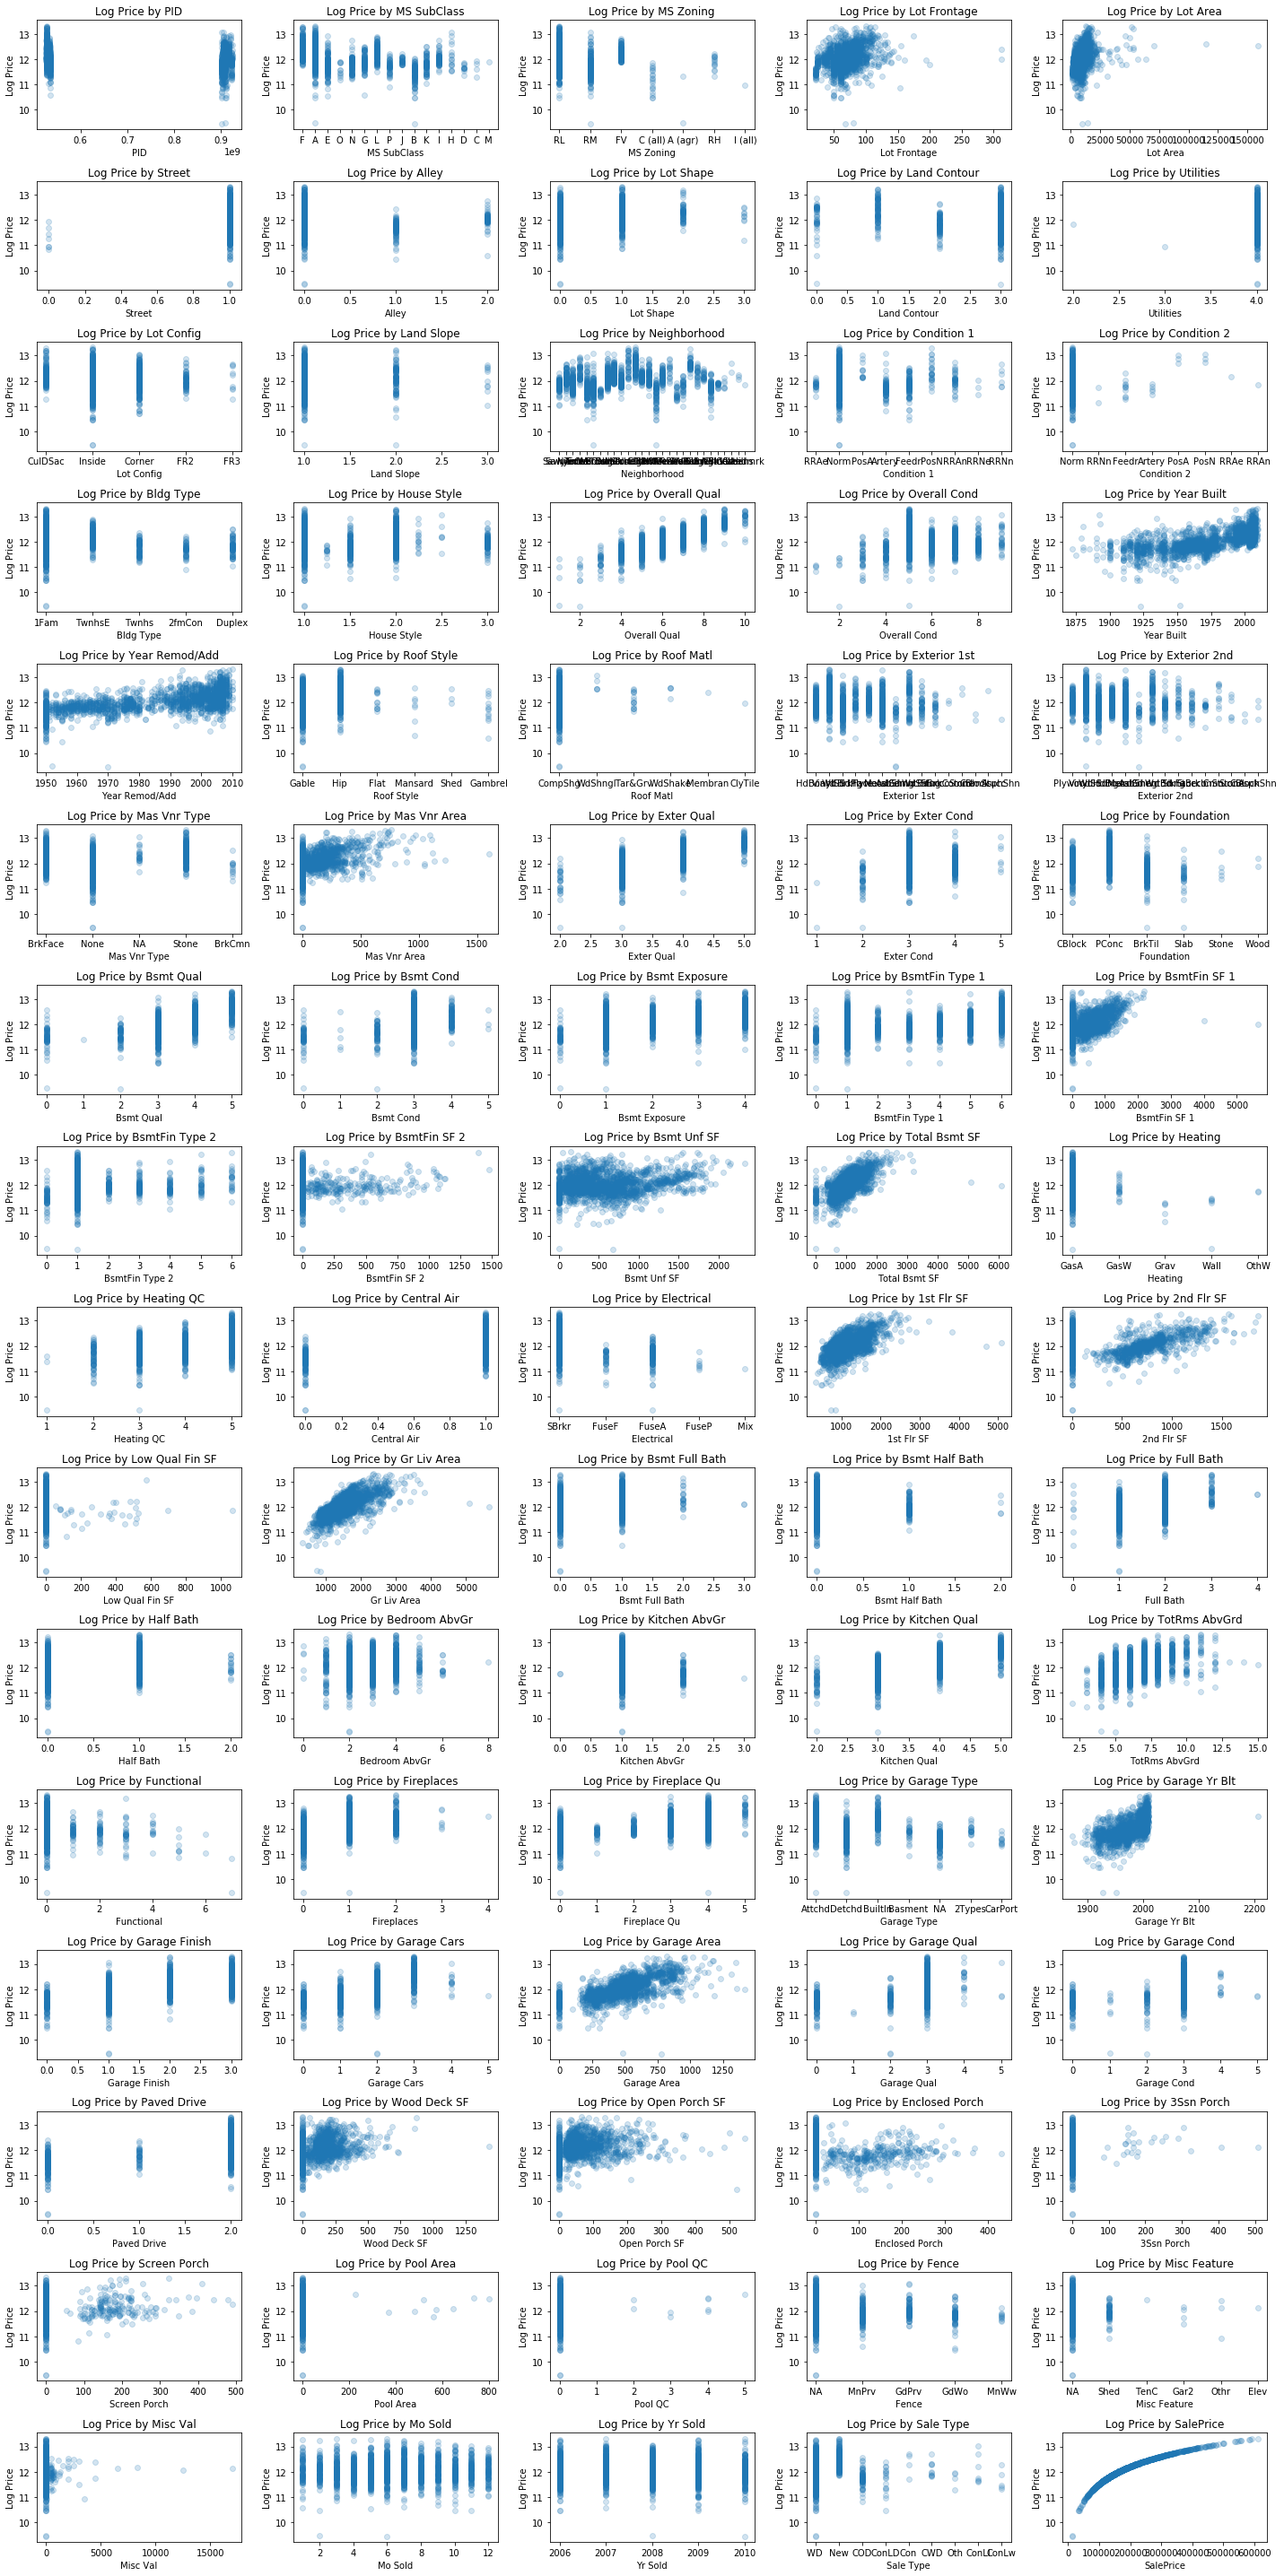

In [85]:
fig, ax = plt.subplots(16, 5, figsize=(20,40))
ax = ax.flatten()

for i, variable in enumerate(housing_train.drop(columns='Log Price').columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])
    
plt.tight_layout()

In [ ]:
# observations:
# - mostly linear relationship with key outliers in price and SF
# - invalid value for Garage Yr Blt
# - lower bound for remod/add is 1950 which is odd
# - 0 values for BsmtFinSF 1 distort linear relationship

### Ranking feature importance

#### Using correlations

In [6]:
feature_importance_corr = abs(housing_train.drop(columns=['PID']).corr()['Log Price']).sort_values(ascending=False)

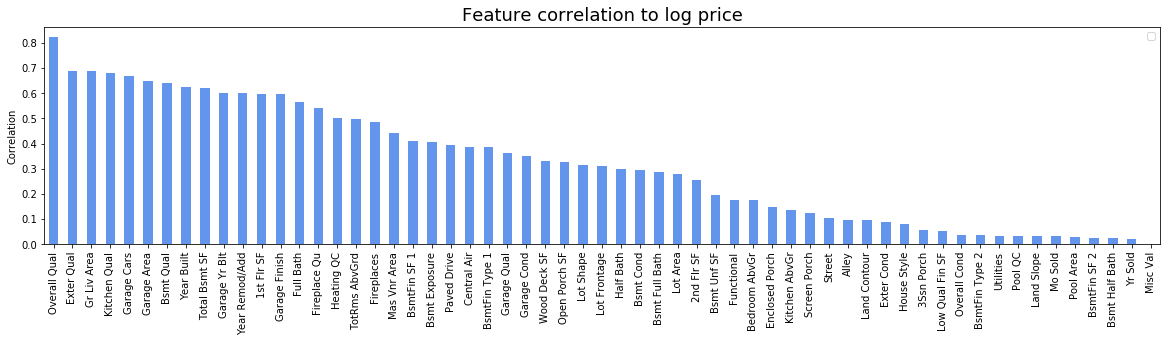

In [7]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_corr[2:].plot.bar(color='cornflowerblue', ax=ax)
ax.set_title('Feature correlation to log price', fontsize=18)
ax.set_ylabel('Correlation')
ax.legend('');

#### Using a random forest

In [8]:
## ranking features helps to know where to focus efforts on feature engineering and selection
## correlations are important, but don't work for categories
## H20 random forest allows analysis of important features across categorical variables also

In [11]:
# connect to h2o by running in terminal:
# import h2o
# h2o.init()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         11 mins 39 secs
H2O cluster timezone:       America/Los_Angeles
H2O data parsing timezone:  UTC
H2O cluster version:        3.20.0.9
H2O cluster version age:    17 days
H2O cluster name:           H2O_from_python_emmalowe_w2bimz
H2O cluster total nodes:    1
H2O cluster free memory:    1.678 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.5 final
--------------------------  ----------------------------------------

In [ ]:
## the analysis above is useful, but only incorporates numerical variables
## H20 random forest allows analysis of important features across categorical variables also

In [12]:
# load dataframe into h2o frame
housing_train_h2oframe = h2o.H2OFrame(housing_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
# build and train model
feature_columns = list(housing_train.drop(columns=['PID', 'SalePrice', 'Log Price']).columns)
rf = h2o.estimators.H2ORandomForestEstimator()
rf.train(x=feature_columns, y='Log Price', training_frame=housing_train_h2oframe)

drf Model Build progress: |███████████████████████████████████████████████| 100%


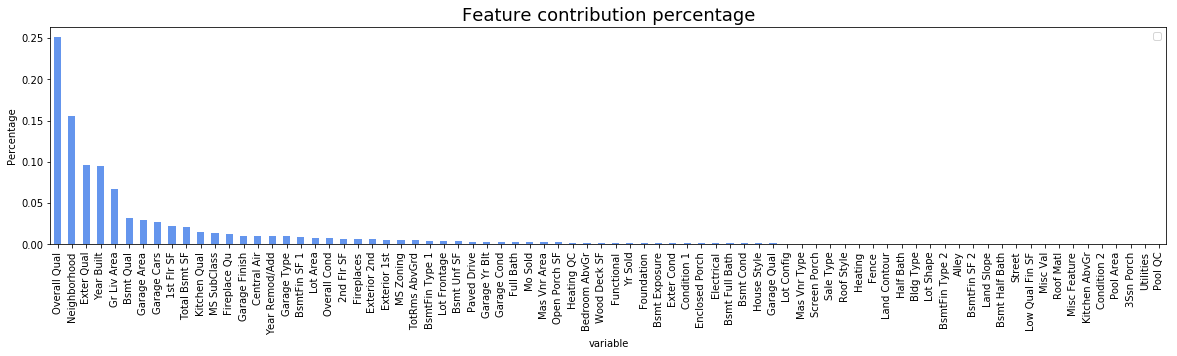

In [14]:
# get and plot feature importance
feature_importance_rf = rf._model_json['output']['variable_importances'].as_data_frame()
feature_importance_rf.set_index('variable', inplace = True)

fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

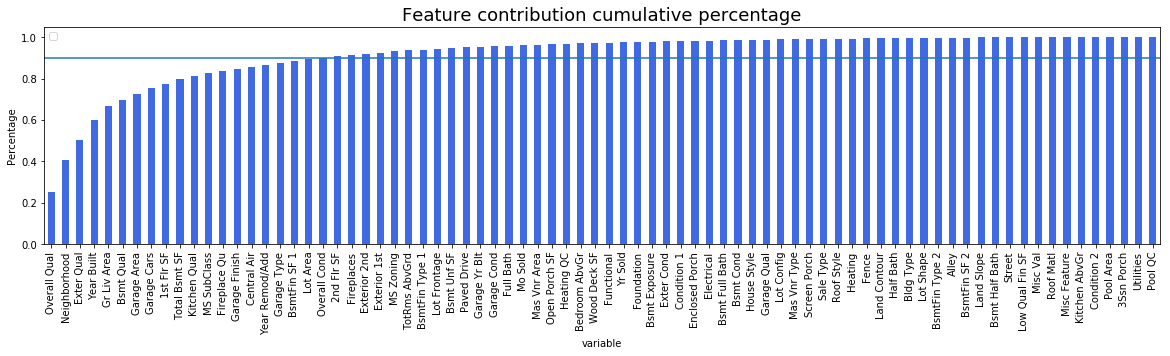

In [15]:
feature_importance_rf['cum_percentage'] = np.cumsum(feature_importance_rf['percentage'])
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='cum_percentage', color='royalblue', ax=ax)
ax.set_title('Feature contribution cumulative percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');
plt.axhline(y = 0.9);

#### Relationship between the two measures

In [16]:
feature_importance_comb = pd.DataFrame(feature_importance_corr[2:])
feature_importance_comb.columns = ['corr']
feature_importance_comb['rf_perc'] = [feature_importance_rf.loc[idx,'percentage'] for idx in feature_importance_comb.index]

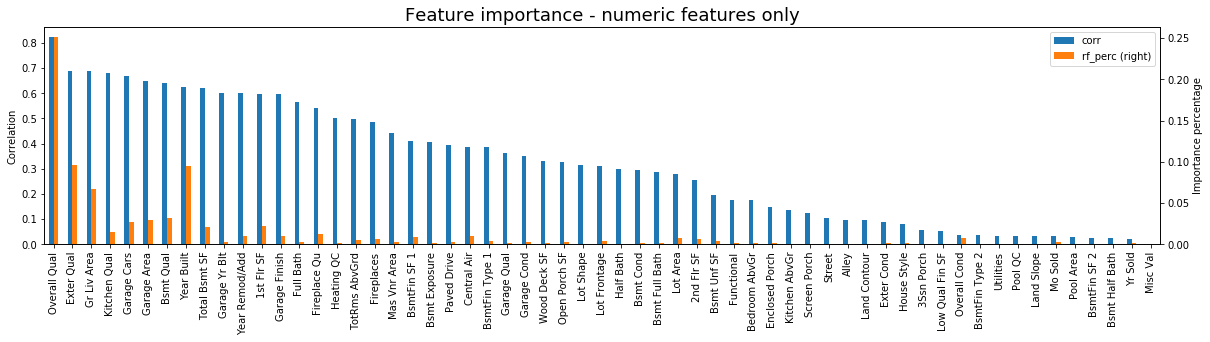

In [58]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))

feature_importance_comb.plot(kind='bar', ax=ax, secondary_y='rf_perc')

ax.set_title('Feature importance - numeric features only', fontsize=18)
ax.set_ylabel('Correlation')
ax.right_ax.set_ylabel('Importance percentage');

In [ ]:
## similar pattern between the two measures

In [51]:
# shouldn't forget that correlations can't capture important categorical features
features_non_numeric = [feature for feature in feature_importance_rf.index if feature not in feature_importance_corr.index]

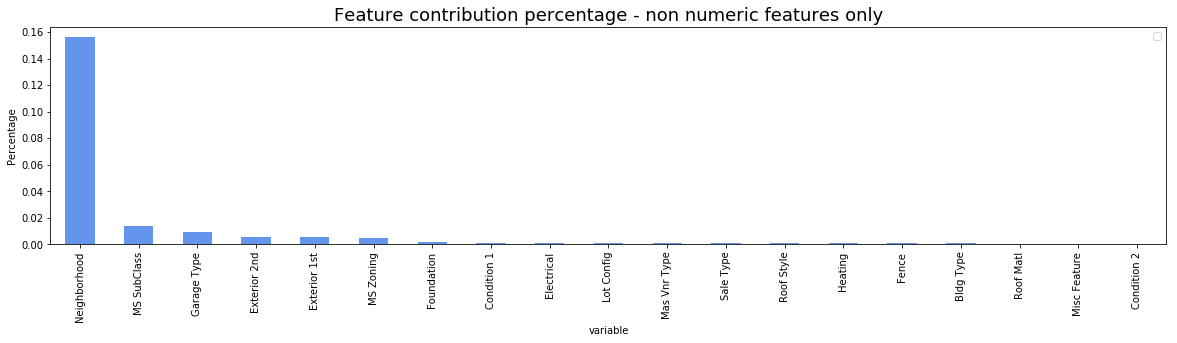

In [57]:
# get and plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.loc[features_non_numeric,:].plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage - non numeric features only', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

## 3. Feature engineering

In [ ]:
#Total SF, Qual, rooms, log transforms

In [69]:
feature_importance_rf[feature_importance_rf['cum_percentage']<0.9]

relative_importance  scaled_importance  percentage  \
variable                                                             
Overall Qual            3391.685791           1.000000    0.251120   
Neighborhood            2106.240967           0.621001    0.155946   
Exter Qual              1304.501831           0.384618    0.096585   
Year Built              1285.877197           0.379126    0.095206   
Gr Liv Area              907.500183           0.267566    0.067191   
Bsmt Qual                426.852264           0.125853    0.031604   
Garage Area              399.639130           0.117829    0.029589   
Garage Cars              357.779449           0.105487    0.026490   
1st Flr SF               295.427582           0.087103    0.021873   
Total Bsmt SF            291.117737           0.085833    0.021554   
Kitchen Qual             193.667114           0.057101    0.014339   
MS SubClass              187.779419           0.055365    0.013903   
Fireplace Qu             163.162125           0.048106    0.012081   
Garage Finish            139.730881           0.041198    0.010346   
Central Air              134.123871           0.039545    0.009931   
Year Remod/Add           132.516083           0.039071    0.009811   
Garage Type              129.789017           0.038267    0.009610   
BsmtFin SF 1             115.738602           0.034124    0.008569   
Lot Area                 107.773384           0.031776    0.007980   

                cum_percentage  
variable                        
Overall Qual          0.251120  
Neighborhood          0.407066  
Exter Qual            0.503652  
Year Built            0.598858  
Gr Liv Area           0.666049  
Bsmt Qual             0.697654  
Garage Area           0.727243  
Garage Cars           0.753733  
1st Flr SF            0.775606  
Total Bsmt SF         0.797161  
Kitchen Qual          0.811500  
MS SubClass           0.825403  
Fireplace Qu          0.837484  
Garage Finish         0.847829  
Central Air           0.857760  
Year Remod/Add        0.867571  
Garage Type           0.877181  
BsmtFin SF 1          0.885750  
Lot Area              0.893730

In [ ]:
## observations:
## - a quarter of variables explain 90% of variation in the model
## - important categorical data include Neighborhood and MS SubClass
## - other important numeric features (not looked at yet) include: Year Built/Remodeled and SF variables

In [ ]:
## some categories have few data points, so it might be worth grouping some categories

In [ ]:
abs(housing_train.corr()['Log Price']).sort_values(ascending=False)[:10]

## 4. Feature selection

### Collinearity

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(abs(housing_train.corr()), cmap='magma_r');

In [ ]:
## some strong multicollinearity between variables (e.g. Garage Cars and Garage Area)


###  Unimportant features

In [ ]:
feature_importance_rf.tail(20)

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20,12))
ax = ax.flatten()

for i, variable in enumerate(feature_importance_rf['variable'].tail(20)):
    try:
        housing_train[variable].plot.hist(ax=ax[i])
    except:
        housing_train[variable].value_counts().plot.bar(ax=ax[i])
    ax[i].set_title(variable)
    ax[i].set_ylabel('Frequency')
    
plt.tight_layout()

In [ ]:
## most low importance features are heavily dominated by one category
## linear regression on categories that have a low number of points is likely to lead to overfitting